# Lab 2 - Clustering
The following implements the k-means and GMM algorithms from scratch. Please use it to augment your understanding of the notes.

In [8]:
import numpy as np
import matplotlib.pyplot as plt   

In [40]:
data = np.load('./Iris_data.npy')
labels = np.load('./Iris_labels.npy')

# Choose two features dimensions to plot, keeping it consistent for the notebook
x_feature = 0
y_feature = 1

## Task 2.2 - K-means Clustering 
The task here is to implement the k-means algorithm. We first define a function to calculate the Euclidean distance between each of the cluster centres and the data, then we initialise our hyper-parameters and create a loop to fit our clusters to the data, iteratively calling the assignment and update operations.

### K-Means algorithm:

Setup: Select random initial set of k cluster centers

Loop:

    for i = 1 to maximum number of iterations
        calculate distance from training points to cluster centroids
        update class labels
        recalculate centroid locations

In [41]:
# Definition of euclidean distance function between cluster centroid and matrix of datapoints
def euclidean_distance(centroids, datapoints):
    dists = np.zeros(shape=[datapoints.shape[0], centroids.shape[0]])
    
    for k in range(centroids.shape[0]):
        differences = datapoints - centroids[k, :]
        sum_of_squared_differences = np.zeros(datapoints.shape[0])
        for dimension in range(centroids.shape[1]):
            sum_of_squared_differences += differences[:, dimension]**2
        dists[:, k] = np.sqrt(sum_of_squared_differences)
        
    return dists


# Definition of k-Means function, iteratively applying the assignment and update operations
def k_means(data, k, n_iteration, verbose=None):
    # Initialize the centroids by randomly selecting k points. Can we do this another way?
    centroids = data[np.random.choice(data.shape[0], k, replace=False), :] 
    
    i = 0
    early_stop = False
    early_stop_tolerance = 1e-5
    while i < n_iteration and not early_stop:
        prev_centroids = centroids
        
        # Assignment step
        dists = euclidean_distance(centroids, data)
        predicted_labels = np.argmin(dists, axis=1)

        # Update step
        new_centroids = np.zeros(shape=[k, data.shape[1]])
        
        for cluster_id in range(k):
            # Get all datapoints alocated to cluster i_k
            cluster_data = data[predicted_labels == cluster_id, :]
            # Calculate the mean of this cluster
            new_centroids[cluster_id, :] = np.mean(cluster_data, axis=0)
            
        centroids = new_centroids
        update_distance = np.sum(np.abs(centroids - prev_centroids))

        # Verbose printing
        if verbose == 'print':
            print(f'Iteration {i}: update distance = {update_distance}')
        elif verbose == 'plot':
            plt.figure()
            plt.scatter(data[:, x_feature], data[:, y_feature], c=predicted_label)
            plt.scatter(centroids[:, x_feature], centroids[:, y_feature], marker='x')
            plt.title(f'k-Means Iteration {i}, Update dist: {update_distance}')
            plt.show()
                
        # Early stopping
        if update_distance < early_stop_tolerance:
            print(f'Early stop on iteration {i}')
            early_stop = True
        
        i += 1

    # One final assignment to get final predictions
    predicted_labels = np.argmin(euclidean_distance(centroids, data), axis=1)
    return predicted_labels, centroids

Iteration 0: update distance = 5.66465390279823
Iteration 1: update distance = 2.3278886018949656
Iteration 2: update distance = 1.9023605321617592
Iteration 3: update distance = 0.9702063660486018
Iteration 4: update distance = 0.5355897165524337
Iteration 5: update distance = 0.21074795192442197
Iteration 6: update distance = 0.08024179891752103
Iteration 7: update distance = 0.0
Early stop on iteration 7


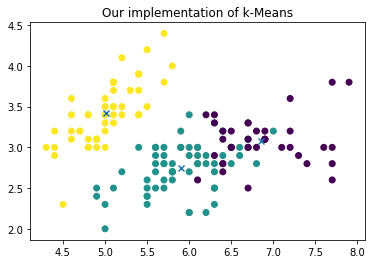

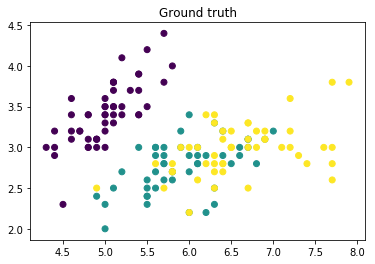

In [49]:
k = 3
n_iteration = 500

predicted_label, k_centroid = k_means(data, k, n_iteration, verbose='print')

# Visualisation of model predictions
plt.figure()
plt.scatter(data[:, x_feature], data[:, y_feature], c=predicted_label)
plt.scatter(k_centroid[:, x_feature], k_centroid[:, y_feature], marker='x')
plt.title('Our implementation of k-Means')
plt.show()

# Visualisation of ground truth
plt.figure()
plt.scatter(data[:, x_feature], data[:, y_feature], c=labels)
plt.title('Ground truth')
plt.show()

## Task 2.3 - Gaussian Mixture Models
The task here is to implement a Gaussian mixture model. We first define some functions for the algorithm, followed by initialisation of the parameters, and finally we implement the loop within which we fit our Gaussians to our data.

### GMM Algorithm:
Setup: Initialise Gaussian distribution centroid, standard deviations and mixing coefficients using k-means coefficients.

Loop: 

    Compute E-Step: calculate posteriors for the data given current Gaussian parameters 
    Compute M-Step: update model parameters 

In [50]:
# E-Step
def multivariate_gaussian_density(x, mu, cov):
    size = x.shape[0]
    det = np.linalg.det(cov)
    norm_const = 1.0 / ((2 * np.pi)**(size / 2) * det ** (1.0 / 2))
    x_mu = x - mu
    inv = np.linalg.inv(cov)
    result = np.e**(-(1.0 / 2) * (x_mu @ inv @ x_mu.T))

    return norm_const * result


# Calculate the posterior probabilities per component for each datapoint
def posterior_prob(x, centroids, cov, mix):
    p = np.zeros([x.shape[0], centroids.shape[0]])
    p_total = np.zeros(x.shape[0])
    posteriors = np.zeros([x.shape[0], centroids.shape[0]])

    for i_sample in range(x.shape[0]):
        for i_cluster in range(centroids.shape[0]):
            p[i_sample, i_cluster] = multivariate_gaussian_density(
                x[i_sample, :].T, centroids[i_cluster, :], cov[:, :, i_cluster])
            p_total[i_sample] = p_total[i_sample] + p[i_sample, i_cluster]

        for i_cluster in range(centroids.shape[0]):
            posteriors[i_sample, i_cluster] = (
                p[i_sample, i_cluster] * mix[i_cluster]) / (p_total[i_sample] * mix[i_cluster])

    return posteriors


# M-Step
def update_params(data, posteriors, mix, cov, centroids):
    # Transpose due to numpy's handling of dimensions
    data = data.T
    
    # Update mixing coefs
    cluster_weight = np.sum(posteriors, axis=0)
    new_mix = (1/data.shape[0]) * cluster_weight

    # Update centroids
    new_centroids = np.zeros(centroids.shape)
    for i_cluster in range(centroids.shape[0]):
        new_centroids[i_cluster, :] = np.sum(posteriors[:, i_cluster] * data, axis=1) / cluster_weight[i_cluster]

    # Update covariance matrices
    new_cov = np.zeros(cov.shape)
    for i_cluster in range(centroids.shape[0]):
        mu_centred_data = data - np.expand_dims(new_centroids[i_cluster, :], axis=-1)
        for i_sample in range(data.shape[1]):
            cov = mu_centred_data[:, i_sample:i_sample+1] @ mu_centred_data[:, i_sample:i_sample+1].T
            scaled_cov = posteriors[i_sample, i_cluster] * cov
            new_cov[:, :, i_cluster] += scaled_cov
            
        new_cov[:, :, i_cluster] /= cluster_weight[i_cluster]

    return new_mix, new_cov, new_centroids


# Definition of GMM function, iteratively applying the E and M steps
def gmm(data, g, n_iteration, verbose=None):
    # Initialise our Gaussian components by randomly selecting datapoints and allocating equal mixing coefficients. 
    # How could we use k-means here?
    centroids = data[np.random.choice(data.shape[0], g, replace=False), :]
    cov = np.repeat(np.cov(data, rowvar = False)[:, :, np.newaxis], g, axis=-1)
    mix = np.ones(g)/g

    i = 0
    early_stop = False
    early_stop_tolerance = 1e-5
    while i < n_iteration and not early_stop:
        prev_centroids = centroids
        
        # E-Step
        posteriors = posterior_prob(data, centroids, cov, mix)
        predicted_labels = np.argmax(posteriors, axis=1)

        # M-Step
        mix, cov, centroids = update_params(
            data, posteriors, mix, cov, centroids)
        
        update_distance = np.sum(np.abs(centroids - prev_centroids))
        
        # Verbose printing
        if verbose == 'print':
            print(f'Iteration {i}: update distance = {update_distance}')
        elif verbose == 'plot':
            plt.figure()
            plt.scatter(data[:, x_feature], data[:, y_feature], c=predicted_label)
            plt.scatter(centroids[:, x_feature], centroids[:, y_feature], marker='x')
            plt.title(f'k-Means Iteration {i}, Update dist: {update_distance}')
            plt.show()
                
        # Early stopping
        if update_distance < early_stop_tolerance:
            print(f'Early stop on iteration {i}')
            early_stop = True
        
        i += 1

    # One final assignment to get final predictions
    predicted_labels = np.argmax(posterior_prob(data, centroids, cov, mix), axis=1)
    return predicted_labels, posteriors, centroids, cov, mix

### Main loop of GMM fitting
Loop over our iterations, computing steps E and M repeatedly.

Iteration 0: update distance = 4.046977556772842
Iteration 1: update distance = 1.6181080658151665
Iteration 2: update distance = 1.1537395461279907
Iteration 3: update distance = 0.5627883511696699
Iteration 4: update distance = 0.47465345022175254
Iteration 5: update distance = 0.4851890960083631
Iteration 6: update distance = 0.24274332105951102
Iteration 7: update distance = 0.2886654302449588
Iteration 8: update distance = 0.3672231565190211
Iteration 9: update distance = 0.36146076186299997
Iteration 10: update distance = 0.2884834248675156
Iteration 11: update distance = 0.18643226333457266
Iteration 12: update distance = 0.09706096092574953
Iteration 13: update distance = 0.053155231527008684
Iteration 14: update distance = 0.031275270162944485
Iteration 15: update distance = 0.020715340385261877
Iteration 16: update distance = 0.016577574017440505
Iteration 17: update distance = 0.014223149769745702
Iteration 18: update distance = 0.01141912171679968
Iteration 19: update dista

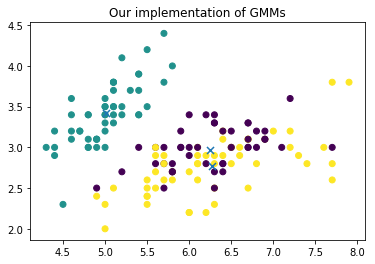

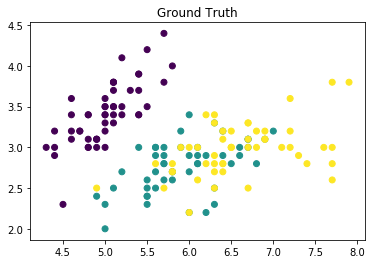

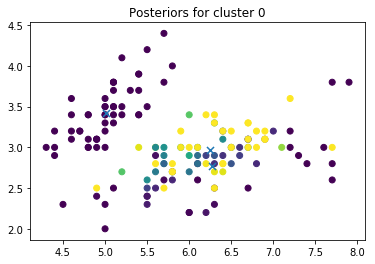

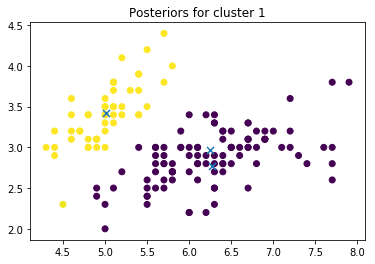

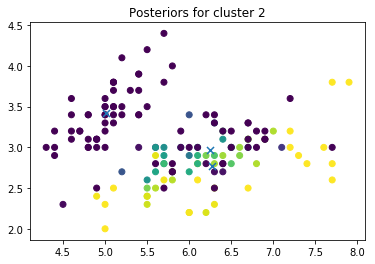

In [55]:
g = 3
n_iteration = 100

predicted_label, posteriors, centroids, cov, mix = gmm(data, g, n_iteration, 'print')

# Visualisation of model predictions
plt.scatter(data[:, x_feature], data[:, y_feature], c=predicted_label)
plt.scatter(centroids[:, x_feature], centroids[:, y_feature], s=50, marker='x')
plt.title('Our implementation of GMMs')
plt.show()

# Visualisation of ground truth
plt.scatter(data[:, x_feature], data[:, y_feature], c=labels)
plt.title('Ground Truth')
plt.show()

# Visualisation of model posteriors
for i_cluster in range(g):
    plt.scatter(data[:, x_feature], data[:, y_feature], c=posteriors[:, i_cluster])
    plt.scatter(centroids[:, x_feature], centroids[:, y_feature], s=50, marker='x')
    plt.title(f'Posteriors for cluster {i_cluster}')
    plt.show()